In [54]:
import time
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
from skimage.feature import hog
from tqdm import tqdm

from utils.load_data import load_split
from utils.ml_training import plot_classification_metrics, plot_model_sizes, plot_training_times, run_ml_experiments
from utils.types import (
    FeatureVector_float32,
    RGBImage_uint8,
)

In [2]:
train_images, train_labels = load_split("data/train/", library="pil")
len(train_images), train_images[0].shape, train_labels.shape

Loading FAKE images: 100%|██████████| 50000/50000 [00:22<00:00, 2251.76it/s]


(100000, (32, 32, 3), (100000,))

In [3]:
test_images, test_labels = load_split("data/test/", library="pil")
len(test_images), test_images[0].shape, test_labels.shape

Loading FAKE images: 100%|██████████| 10000/10000 [00:07<00:00, 1257.86it/s]


(20000, (32, 32, 3), (20000,))

In [55]:
# HOG parameters (for 32x32 images)
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)

In [73]:
def extract_hog_feature(
    img: RGBImage_uint8,
    orientations: int,
    pixels_per_cell: tuple[int, int],
    cells_per_block: tuple[int, int],
) -> FeatureVector_float32:
    """Extract Histogram of Oriented Gradients (HOG) features from a grayscale image."""
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    feat = hog(
        gray,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm="L2",
        feature_vector=True,
    )
    return feat.astype(np.float32)

In [74]:
extract_hog_feature(train_images[0], HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK).shape

(324,)

In [75]:
hog_features_list_train: list[FeatureVector_float32] = [
    extract_hog_feature(img, HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK)
    for img in tqdm(train_images, desc="Extracting HOG features from train images")
]
hog_features_list_test: list[FeatureVector_float32] = [
    extract_hog_feature(img, HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK)
    for img in tqdm(test_images, desc="Extracting HOG features from test images")
]

Extracting HOG features from test images: 100%|██████████| 20000/20000 [00:02<00:00, 7913.13it/s]


In [76]:
real_hog_feat: FeatureVector_float32 = np.array(hog_features_list_train)[:50000].mean(axis=0)
fake_hog_feat: FeatureVector_float32 = np.array(hog_features_list_train)[50000:].mean(axis=0)

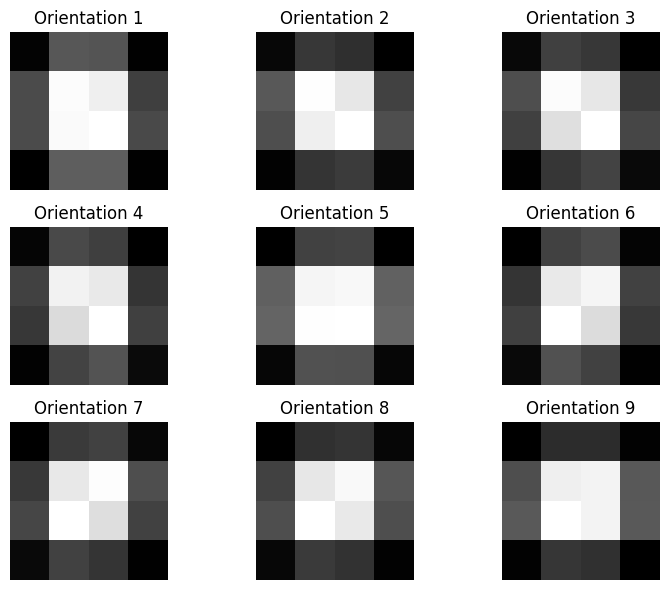

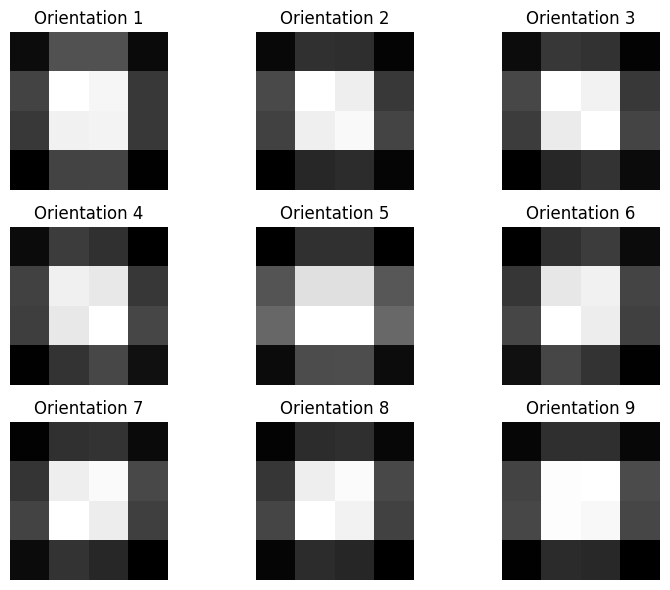

In [77]:
def visualize_hog_orientations(vec: FeatureVector_float32) -> None:
    """Visualize HOG orientation bins."""
    n_cells_x = 32 // HOG_PIXELS_PER_CELL[1]
    n_cells_y = 32 // HOG_PIXELS_PER_CELL[0]
    n_blocks_x = (n_cells_x - HOG_CELLS_PER_BLOCK[1]) + 1
    n_blocks_y = (n_cells_y - HOG_CELLS_PER_BLOCK[0]) + 1
    n_orientations = HOG_ORIENTATIONS
    hog_image = vec.reshape(n_blocks_y, n_blocks_x, HOG_CELLS_PER_BLOCK[0], HOG_CELLS_PER_BLOCK[1], n_orientations)
    # Sum over blocks
    cells = np.zeros((n_cells_y, n_cells_x, n_orientations), dtype=np.float32)
    for by in range(n_blocks_y):
        for bx in range(n_blocks_x):
            for cy in range(HOG_CELLS_PER_BLOCK[0]):
                for cx in range(HOG_CELLS_PER_BLOCK[1]):
                    cells[by + cy, bx + cx, :] += hog_image[by, bx, cy, cx, :]
    # Plotting
    plt.figure(figsize=(8, 6))
    for o in range(n_orientations):
        plt.subplot(3, 3, o + 1)
        plt.imshow(cells[:, :, o], cmap="gray")
        plt.title(f"Orientation {o + 1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


visualize_hog_orientations(real_hog_feat)
visualize_hog_orientations(fake_hog_feat)

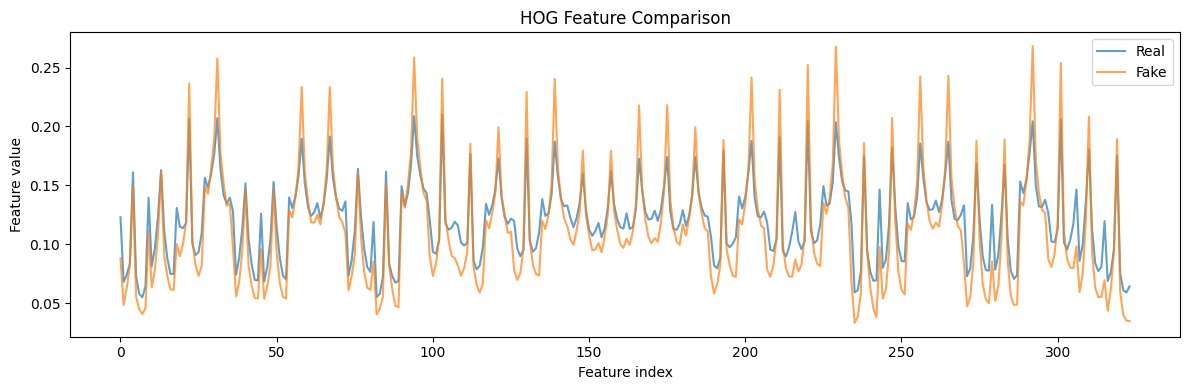

In [78]:
def compare_hog_features(
    feat1: FeatureVector_float32,
    feat2: FeatureVector_float32,
    labels: tuple[str, str] = ("Real", "Fake"),
) -> None:
    plt.figure(figsize=(12, 4))
    plt.plot(feat1, label=labels[0], alpha=0.7)
    plt.plot(feat2, label=labels[1], alpha=0.7)
    plt.title("HOG Feature Comparison")
    plt.xlabel("Feature index")
    plt.ylabel("Feature value")
    plt.legend()
    plt.tight_layout()
    plt.show()


# example:
compare_hog_features(real_hog_feat, fake_hog_feat)

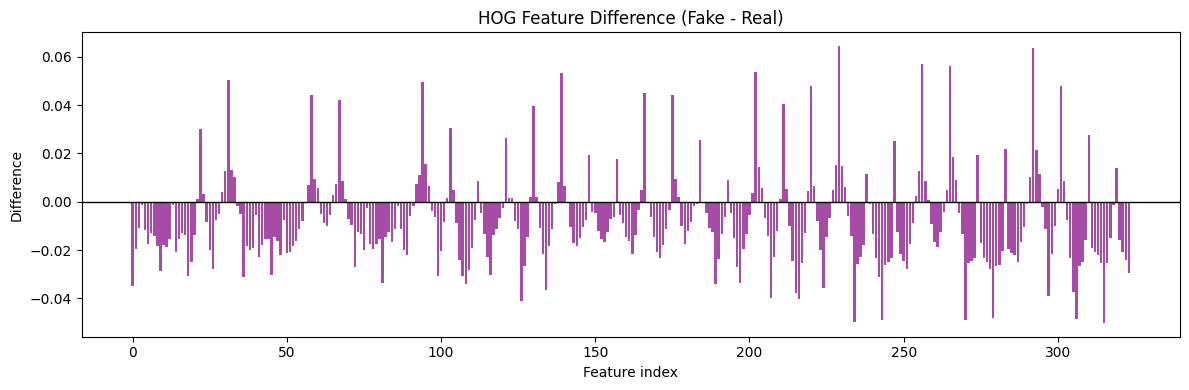

In [79]:
def compare_hog_features_diff(feat1: FeatureVector_float32, feat2: FeatureVector_float32) -> None:
    diff = feat2 - feat1
    x = np.arange(len(feat1))

    plt.figure(figsize=(12, 4))
    plt.bar(x, diff, color="purple", alpha=0.7)
    plt.axhline(0, color="black", linewidth=1)
    plt.title("HOG Feature Difference (Fake - Real)")
    plt.xlabel("Feature index")
    plt.ylabel("Difference")
    plt.tight_layout()
    plt.show()


compare_hog_features_diff(real_hog_feat, fake_hog_feat)

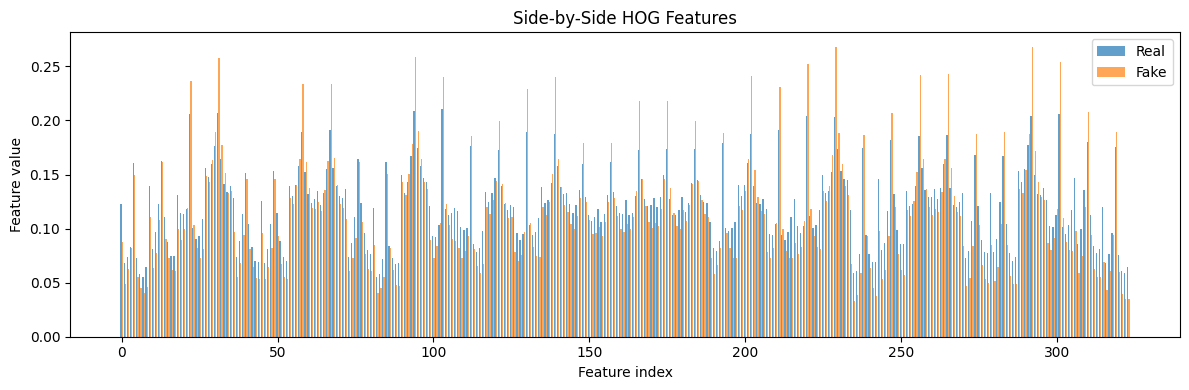

In [80]:
def side_by_side_hog(real_feat: FeatureVector_float32, fake_feat: FeatureVector_float32) -> None:
    x = np.arange(len(real_feat))

    plt.figure(figsize=(12, 4))
    plt.bar(x - 0.2, real_feat, width=0.4, label="Real", alpha=0.7)
    plt.bar(x + 0.2, fake_feat, width=0.4, label="Fake", alpha=0.7)
    plt.title("Side-by-Side HOG Features")
    plt.xlabel("Feature index")
    plt.ylabel("Feature value")
    plt.legend()
    plt.tight_layout()
    plt.show()


side_by_side_hog(real_hog_feat, fake_hog_feat)

In [97]:
X_train = np.array(hog_features_list_train)
y_train = train_labels
X_test = np.array(hog_features_list_test)
y_test = test_labels

In [98]:
# make X_train and y_train into dataframes
import pandas as pd

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.Series(y_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.Series(y_test)
df_train = pd.concat([X_train_df, y_train_df], axis=1)
df_test = pd.concat([X_test_df, y_test_df], axis=1)
df_train.columns = [f"HOG_{i}" for i in range(X_train.shape[1])] + ["label"]
df_test.columns = [f"HOG_{i}" for i in range(X_test.shape[1])] + ["label"]

In [99]:
df_train

,HOG_0,HOG_1,HOG_2,HOG_3,HOG_4,HOG_5,HOG_6,HOG_7,HOG_8,HOG_9,...,HOG_315,HOG_316,HOG_317,HOG_318,HOG_319,HOG_320,HOG_321,HOG_322,HOG_323,label
0,0.164556,0.110298,0.114931,0.271179,0.169717,0.054026,0.000000,0.013909,0.032058,0.128274,...,0.178965,0.071544,0.034731,0.160832,0.215133,0.077233,0.080584,0.174348,0.053133,0
1,0.042332,0.014491,0.008546,0.186208,0.458941,0.127396,0.026936,0.002414,0.010556,0.044536,...,0.016068,0.005337,0.001035,0.058476,0.338194,0.090360,0.037042,0.018520,0.009288,0
2,0.171644,0.030002,0.085235,0.000000,0.293204,0.312434,0.416592,0.135259,0.200463,0.170252,...,0.116966,0.040826,0.000000,0.157485,0.174811,0.229987,0.108690,0.194863,0.189121,0
3,0.137398,0.000000,0.039423,0.076545,0.318370,0.238697,0.182499,0.100955,0.084661,0.228457,...,0.025416,0.000000,0.005985,0.154246,0.773984,0.022197,0.002287,0.006587,0.000000,0
4,0.052806,0.023038,0.244265,0.088502,0.200047,0.125870,0.030002,0.026564,0.000000,0.116017,...,0.154710,0.076618,0.048245,0.139931,0.181676,0.019553,0.061611,0.012055,0.039013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.179876,0.069526,0.020100,0.012456,0.096158,0.091347,0.146748,0.079922,0.105539,0.675394,...,0.061387,0.000000,0.008104,0.008416,0.235343,0.139921,0.002652,0.029294,0.019659,1
99996,0.041027,0.010263,0.003078,0.008829,0.006192,0.008280,0.004104,0.002433,0.002294,0.036792,...,0.036066,0.019112,0.030317,0.039142,0.072664,0.010907,0.021799,0.007732,0.041020,1
99997,0.016254,0.007179,0.007823,0.061754,0.164849,0.082485,0.000000,0.003312,0.005464,0.024837,...,0.010583,0.000000,0.017263,0.123733,0.321867,0.104762,0.007199,0.007624,0.000000,1
99998,0.045997,0.039485,0.027933,0.010695,0.014838,0.010823,0.005699,0.009675,0.013169,0.709950,...,0.115833,0.062816,0.177663,0.082806,0.313390,0.030356,0.000000,0.004480,0.068241,1


In [100]:
df_test

,HOG_0,HOG_1,HOG_2,HOG_3,HOG_4,HOG_5,HOG_6,HOG_7,HOG_8,HOG_9,...,HOG_315,HOG_316,HOG_317,HOG_318,HOG_319,HOG_320,HOG_321,HOG_322,HOG_323,label
0,0.133233,0.147257,0.155707,0.247196,0.234899,0.161379,0.039895,0.113214,0.084901,0.012819,...,0.221702,0.220815,0.207102,0.148685,0.139678,0.046422,0.103002,0.022021,0.095391,0
1,0.059590,0.010019,0.035142,0.322201,0.252297,0.047138,0.013749,0.005209,0.004802,0.064328,...,0.064858,0.141359,0.082815,0.041605,0.027038,0.058822,0.060822,0.108954,0.021148,0
2,0.102442,0.017749,0.145625,0.067538,0.116081,0.014466,0.020879,0.016245,0.017870,0.038912,...,0.162728,0.056431,0.104525,0.113858,0.246311,0.130088,0.113036,0.048274,0.146711,0
3,0.126457,0.061866,0.000678,0.056195,0.104592,0.047203,0.015626,0.116695,0.055012,0.178866,...,0.227151,0.197967,0.370338,0.180816,0.171524,0.047681,0.013201,0.034434,0.114480,0
4,0.198966,0.074091,0.031344,0.263441,0.384085,0.199880,0.073618,0.047190,0.069013,0.186227,...,0.147104,0.090647,0.060828,0.107004,0.084967,0.000000,0.016345,0.015751,0.055143,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.006510,0.000903,0.001771,0.027221,0.539011,0.178120,0.015349,0.005492,0.002615,0.022876,...,0.002537,0.000000,0.004492,0.017252,0.334163,0.019668,0.001345,0.001802,0.000951,1
19996,0.087336,0.059084,0.456215,0.301742,0.123053,0.007774,0.005324,0.005364,0.005336,0.052208,...,0.061129,0.031787,0.059596,0.098990,0.081779,0.074847,0.040693,0.056111,0.012820,1
19997,0.031245,0.058664,0.113029,0.160565,0.360398,0.142329,0.044983,0.000000,0.025460,0.015879,...,0.071263,0.025646,0.151133,0.160663,0.217494,0.061118,0.072447,0.047887,0.033145,1
19998,0.108328,0.005567,0.005401,0.136069,0.195121,0.066361,0.034718,0.013022,0.003937,0.097713,...,0.022440,0.028015,0.038334,0.118442,0.128676,0.046089,0.022709,0.008831,0.019224,1


In [101]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 325 entries, HOG_0 to label
dtypes: float32(324), uint8(1)
memory usage: 123.7 MB


In [102]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 325 entries, HOG_0 to label
dtypes: float32(324), uint8(1)
memory usage: 24.7 MB


In [103]:
df_train.to_csv("data/hog_train_features.csv", index=False)
df_test.to_csv("data/hog_test_features.csv", index=False)

In [82]:
rng = np.random.RandomState(42)
shuffle_indices = rng.permutation(len(X_train))

X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]

In [83]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((100000, 324), (20000, 324), (100000,), (20000,))

In [84]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

(dtype('float32'), dtype('float32'), dtype('uint8'), dtype('uint8'))

In [85]:
real_hog_feat

array([0.12285843, 0.06788917, 0.07374851, 0.08341549, 0.16095151,
       0.07275718, 0.05786821, 0.05485743, 0.06417437, 0.13932979,
       0.08119022, 0.09644708, 0.12302301, 0.16284512, 0.11113109,
       0.08803315, 0.07469294, 0.07482383, 0.13080874, 0.11482209,
       0.1136547 , 0.11778918, 0.20626332, 0.10062155, 0.09073627,
       0.09320619, 0.10921645, 0.15648428, 0.14777562, 0.15940884,
       0.17605664, 0.20702736, 0.16398844, 0.14167877, 0.1343224 ,
       0.13948654, 0.1281955 , 0.0740946 , 0.08834109, 0.11360342,
       0.15155068, 0.10427696, 0.08263135, 0.06962571, 0.06924418,
       0.1258378 , 0.06835778, 0.08082449, 0.1039689 , 0.1528823 ,
       0.11403191, 0.08816967, 0.07349699, 0.07014085, 0.13966873,
       0.13060056, 0.14050081, 0.15798719, 0.1894625 , 0.15194136,
       0.13174261, 0.12397466, 0.12700486, 0.13493356, 0.12218086,
       0.13304949, 0.15486418, 0.19138235, 0.1565171 , 0.13934535,
       0.1302342 , 0.1283201 , 0.13638018, 0.07338753, 0.08625

In [86]:
path_output = Path("outputs/hog_classification_results.json")
results = run_ml_experiments(X_train, y_train, X_test, y_test, path_output)


GaussianNB:
Training time: 0.14 seconds
              precision    recall  f1-score   support

        Real     0.6470    0.6584    0.6527     10000
        Fake     0.6523    0.6408    0.6465     10000

    accuracy                         0.6496     20000
   macro avg     0.6496    0.6496    0.6496     20000
weighted avg     0.6496    0.6496    0.6496     20000

Model size (joblib): 0.005 MB

KNeighborsClassifier:
Training time: 0.01 seconds
              precision    recall  f1-score   support

        Real     0.7333    0.7715    0.7519     10000
        Fake     0.7589    0.7194    0.7386     10000

    accuracy                         0.7454     20000
   macro avg     0.7461    0.7454    0.7453     20000
weighted avg     0.7461    0.7454    0.7453     20000

Model size (joblib): 108.273 MB

LogisticRegression:
Training time: 5.52 seconds
              precision    recall  f1-score   support

        Real     0.7137    0.7044    0.7090     10000
        Fake     0.7082    0.7174 

d:\AT82.08-AI-Generated-Image-Classification\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


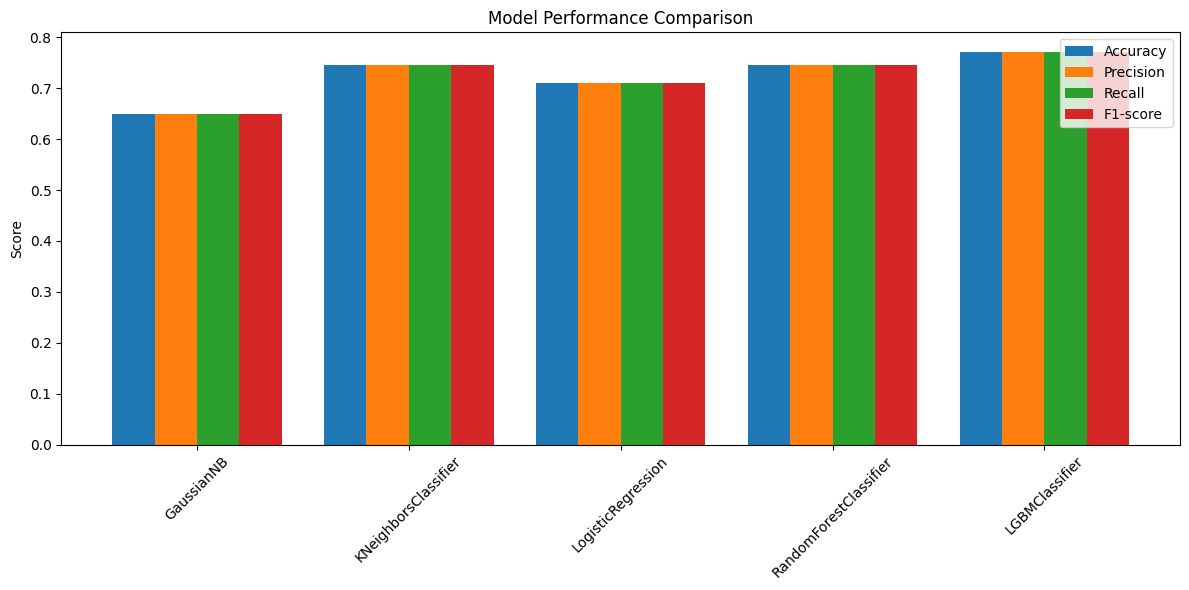

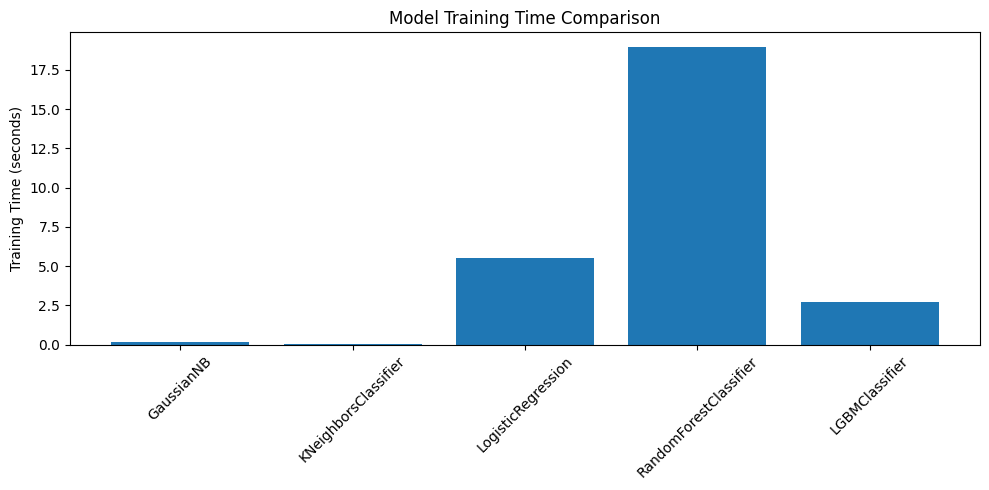

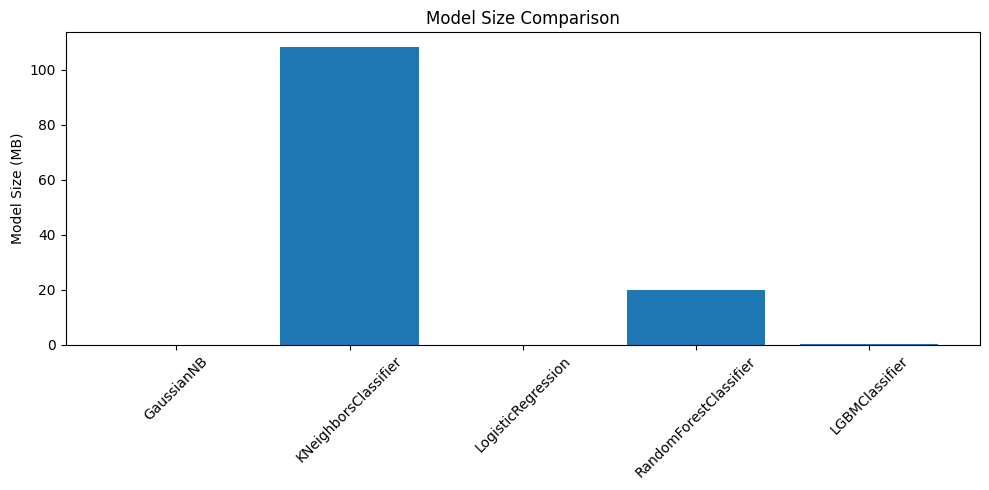

In [87]:
plot_classification_metrics(results)
plot_training_times(results)
plot_model_sizes(results)